# TEST DEEP LEARNING

blog: 

https://mateuszbuda.github.io/2018/03/06/colab.html 

### Installing some packages

- keras - deep learning
- scikit-learn - general purpose machine learning
- imbalanced-learn - methods that address class imbalance problem

In [1]:
!pip install keras scikit-learn imbalanced-learn


### Let's verify that we have a GPU available

The following cell should output a GPU device 0 with `name: Tesla K80`

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15711927061297701228]

### Imports that we'll use along the way

- numpy - linear algebra
- keras - deep learning
- sklearn.dataset - to download Labeled Faces in the Wild dataset
- sklearn.model_selection - for dataset train/test split
- sklearn.metrics - to measure the performance of our classifier
- matplotlib.pyplot - showing images and plots
- imblearn.over_sampling - random oversampling method to handle class imalance

In [4]:
import numpy as np
import keras
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


ImportError: A sklearn version of at least 0.19.0 is required to use imbalanced-learn. 0.18.2 was found. Please upgrade sklearn

### Labeled Faces in the Wild dataset

The cell below downloads the dataset using `fetch_lfw_people` function and checks the dimensionality of the datset.

There are some parameters that control e.g. the minimum number of images per class (person), image size, etc.

Here is a link to the function's documentation: [fetch_lfw_people](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html).

In [4]:
lfw_people = fetch_lfw_people(min_faces_per_person=20, color=True, resize=1.0,
                              slice_=(slice(48, 202), slice(48, 202)))

X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print('number of examples: {}'.format(y.shape[0]))
print('dimensionality of images: {}'.format(X.shape[1:]))
print('number of unique classes (people): {}'.format(n_classes))

/usr/local/lib/python2.7/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python2.7/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


number of examples: 3023
dimensionality of images: (154, 154, 3)
number of unique classes (people): 62


Let's plot a histogram showing how many examples per class we have.

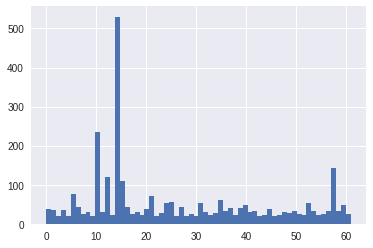

In [5]:
_ = plt.hist(y, bins=n_classes)

Since the dataset contains images, we'll display a random image together with its label.

Hugo Chavez


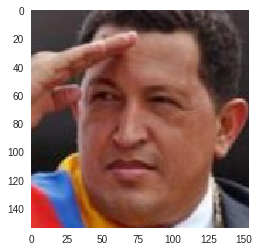

In [7]:
i = np.random.randint(len(lfw_people.images))
plt.imshow(lfw_people.images[i] * 255)
plt.grid(False)
print(target_names[y[i]])

### Deep learning

Now let's get down to deep learning and build an All Convolutional Net inspired model [Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806).

First, we need to import some layer objects from Keras.

In [0]:
from keras.layers import Input
from keras.layers import Conv2D, GlobalAvgPool2D
from keras.layers import Dropout, Activation

Below we define our model.
It consists of 10 convolutional layers with increasing number of filters (from 12 to 48).
Every second layer has kernels of size `(2, 2)` with strides `(2, 2)` and serves the purpose of a trainable pooling layer since it reduces spacial dimensionality.
After that, we add Dropout for regularization which sets 50% of randomly chosen activations to 0.
Then, we add the last convolutional layer for dimensionality expansion to match the number of classes that we predict.
Finallly, we apply global average polling to squash spacial dimenaions.
We could do that with another convolutional layer or a fully connected leyer, however, it would increase the number of weights to train and, in turn, a risk of overfitting.


In [0]:
input = Input(shape=X.shape[1:])                                  # 154x154x3
x = Conv2D(12, (3, 3), padding='same', activation='relu')(input)  # 154x154x12
x = Conv2D(12, (2, 2), strides=(2, 2), activation='relu')(x)      # 77x77x12
x = Conv2D(16, (3, 3), padding='same', activation='relu')(x)      # 77x77x16
x = Conv2D(16, (2, 2), strides=(2, 2), activation='relu')(x)      # 38x38x16
x = Conv2D(24, (3, 3), padding='same', activation='relu')(x)      # 38x38x24
x = Conv2D(24, (2, 2), strides=(2, 2), activation='relu')(x)      # 19x19x24
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)      # 19x19x32
x = Conv2D(32, (2, 2), strides=(2, 2), activation='relu')(x)      # 9x9x32
x = Conv2D(48, (3, 3), padding='same', activation='relu')(x)      # 9x9x48
x = Conv2D(48, (2, 2), strides=(2, 2), activation='relu')(x)      # 4x4x48
x = Dropout(0.5)(x)                                               # 4x4x48
x = Conv2D(n_classes, (1, 1))(x)                                  # 4x4x62
x = GlobalAvgPool2D()(x)                                          # 62
output = Activation('softmax')(x)                                 # 62

Now, let's create a `DataGenerator` object that will add some data augmentation to prevent overfitting.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1)

### Training

At this point we are ready to define training procedure that involves setting some hyperparameters, e.g. batch size, optimization algorithm and base learning rate, number of epochs, etc.

In addition, since we know that our dataset is imbalanced, it's good to use oversampling, as it was shown in [A systematic study of the class imbalance problem in convolutional neural networks](https://arxiv.org/abs/1710.05381).

In [2]:
from datetime import datetime
#Compare training time. 
print("___Start!___" +  datetime.now().strftime('%H:%M:%S')  )


___Start!___11:13:48


In [12]:
from keras import Model

batch_size = 256
test_split = 0.2
base_lr = 0.001
epochs = 100

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, 
                                                    stratify=y, random_state=42)

# oversampling each class to contain at least 256 examples
sampling_targets = np.maximum([256] * n_classes, np.bincount(y_train))
ratio_dict = dict(zip(range(n_classes), sampling_targets))
ros = RandomOverSampler(ratio=ratio_dict, random_state=42)

X_train_shape = X_train.shape
X_train = np.reshape(X_train, (X_train_shape[0], -1))
X_train, y_train = ros.fit_sample(X_train, y_train)
X_train = np.reshape(X_train, (len(X_train),) + X_train_shape[1:])

# one-hot encoding of labels
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

# compile model and define optimization
model = Model(inputs=input, outputs=output)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Nadam(lr=base_lr),
              metrics=['accuracy'])

# model training 🎉
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/100
62/62 [==============================] - 87s 1s/step - loss: 4.1275 - acc: 0.0224 - val_loss: 4.0676 - val_acc: 0.1636
Epoch 2/100
62/62 [==============================] - 83s 1s/step - loss: 4.0618 - acc: 0.0333 - val_loss: 3.8757 - val_acc: 0.0661
Epoch 3/100
62/62 [==============================] - 83s 1s/step - loss: 3.8877 - acc: 0.0467 - val_loss: 3.7591 - val_acc: 0.0909
Epoch 4/100
62/62 [==============================] - 84s 1s/step - loss: 3.7218 - acc: 0.0677 - val_loss: 3.6288 - val_acc: 0.0529
Epoch 5/100
44/62 [====================>.........] - ETA: 24s - loss: 3.6040 - acc: 0.083062/62 [==============================] - 84s 1s/step - loss: 3.5839 - acc: 0.0867 - val_loss: 3.4594 - val_acc: 0.0959
Epoch 6/100
62/62 [==============================] - 84s 1s/step - loss: 3.4127 - acc: 0.1215 - val_loss: 3.5209 - val_acc: 0.1488
Epoch 7/100
62/62 [==============================] - 84s 1s/step - loss: 3.2611 - acc: 0.1531 - val_loss: 3.1903 - val_acc: 0.1719
Epoch

56/62 [==========================>...] - ETA: 8s - loss: 0.5569 - acc: 0.825362/62 [==============================] - 85s 1s/step - loss: 0.5486 - acc: 0.8280 - val_loss: 0.8886 - val_acc: 0.7702
Epoch 58/100
62/62 [==============================] - 85s 1s/step - loss: 0.4916 - acc: 0.8441 - val_loss: 0.8874 - val_acc: 0.7702
Epoch 59/100
62/62 [==============================] - 85s 1s/step - loss: 0.4810 - acc: 0.8488 - val_loss: 0.8442 - val_acc: 0.7950
Epoch 60/100
62/62 [==============================] - 85s 1s/step - loss: 0.4811 - acc: 0.8485 - val_loss: 0.8219 - val_acc: 0.7967
Epoch 61/100
56/62 [==========================>...] - ETA: 8s - loss: 0.4507 - acc: 0.858762/62 [==============================] - 85s 1s/step - loss: 0.4602 - acc: 0.8559 - val_loss: 0.8949 - val_acc: 0.7818
Epoch 62/100
62/62 [==============================] - 85s 1s/step - loss: 0.4577 - acc: 0.8559 - val_loss: 0.8583 - val_acc: 0.7851
Epoch 63/100
62/62 [==============================] - 85s 1s/step -

In [3]:
print("end!___" +  datetime.now().strftime('%H:%M:%S')  )


end!___11:13:52


# Save model and visualizations

In [0]:
model.save('weights.h5')

Save the trained weights to your Google Drive.

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html

# 2. Create & upload a file text file.
uploaded = drive.CreateFile({'title': 'weights.h5'})
uploaded.SetContentFile('weights.h5')
uploaded.Upload()

## Train chart
Let's plot the training history in terms of accuracy.

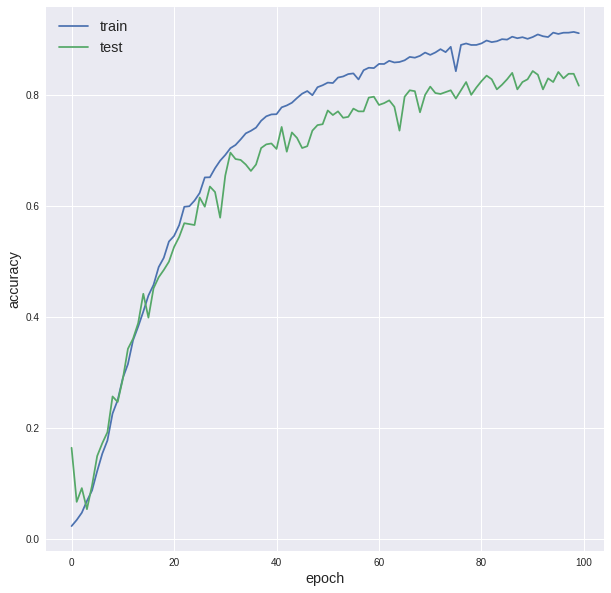

In [15]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy', fontsize='x-large')
plt.xlabel('epoch', fontsize='x-large')
plt.legend(['train', 'test'], loc='upper left', fontsize='x-large')

Get predictions from the test set to visualize the results.

In [16]:
y_pred = model.predict(X_test, batch_size=len(X_test), verbose=1)
y_pred = np.argmax(y_pred, axis=1)

605/605 [==============================] - 2s 3ms/step


## Confusion Matrix
We know that we reached the overall accuracy of 85%.
The more in-depth view we can get by looking at the confusion matix.

In [0]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(0, len(classes), 2)
    plt.xticks(tick_marks, classes[tick_marks], rotation=90)
    plt.yticks(tick_marks, classes[tick_marks])
    plt.ylabel('True label', fontsize='x-large')
    plt.xlabel('Predicted label', fontsize='x-large')

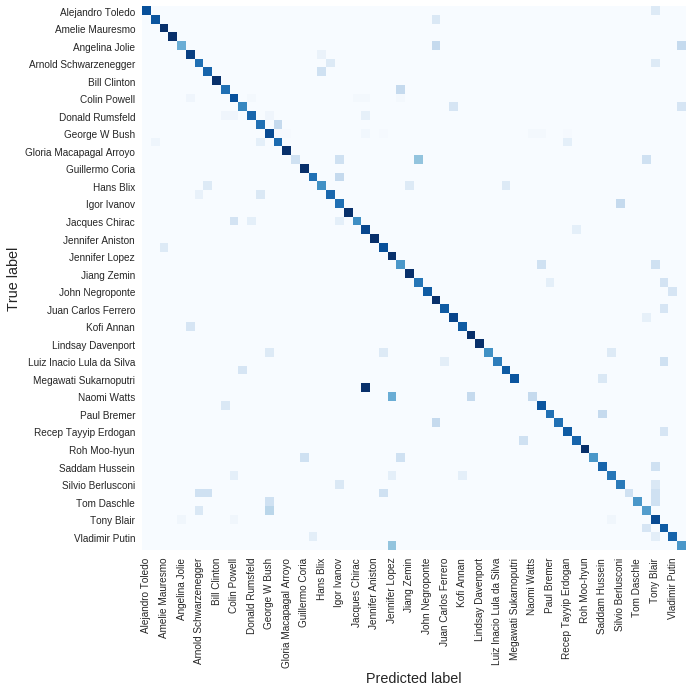

In [18]:
plt.figure(figsize=(10, 10))
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm, classes=target_names)
plt.grid(False)

## Accuracy among all classes
Assuming that all classes have the same importance, more appropriate measure would be the average accuracy among all classes.

In [0]:
def plot_barh(labels, values):
    fig = plt.figure(figsize=(12, 8))
    y_pos = np.arange(len(labels))
    plt.barh(y_pos, values, align='center', alpha=0.5)
    plt.yticks(y_pos, labels)
    plt.xticks(np.arange(0.0, 1.0, 0.05))
    plt.xlabel('accuracy', fontsize='x-large')
    plt.axes().xaxis.grid(color='black', linestyle='-', linewidth=0.5)
    axes = plt.gca()
    axes.set_xlim([0.0, 1.0])
    axes.axvline(np.mean(values), color='green', linewidth=2)
    plt.tight_layout()

In [0]:
class_accuracies = [cm[i, i] for i in range(cm.shape[0])]

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


average accuracy: 77.6%


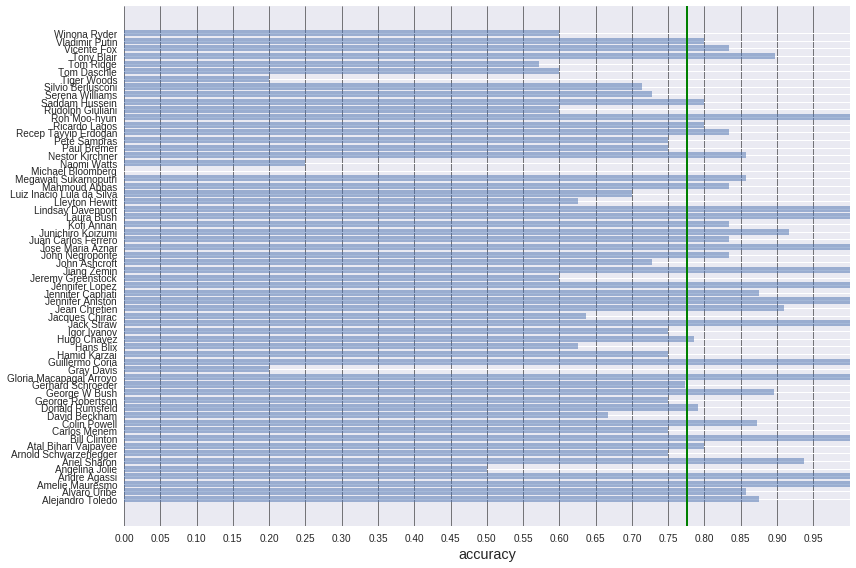

In [21]:
plot_barh(target_names, class_accuracies)
print('average accuracy: {}%'.format(np.round(np.mean(class_accuracies) * 100.0, 1)))